# Assignment 6 - Model Complexity & Regularization

## Learning goals
After successfully completing this assignment, you should understand: 
* the concept of model complexity on an intuitive level
* how one can use regularization to (smoothly) decrease the size of hypothesis space
* how to implement regularization by adding a penalty term
* how to implement regularization by data augmentation
* the relation between adding a penalty-term and data augmentation

In [34]:
%config Completer.use_jedi = False  # enable code auto-completion
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.datasets import make_regression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error

import random
sns.set_style("darkgrid")

# Model Complexity
In previous assignments, we've seen the basic workflow for applying a supervised machine learning model:

- choose a model class and its hyperparameters
- fit the model to the training data
- use the model to predict labels for new data
- assess the model on unseen data (validation set)


Now the question of core importance is if our estimator is underperforming, how should we move forward? There are several possible answers:

- use a more complex/more flexible model
- use a less complex/less flexible model
- gather more training samples
- gather more data to add features to each sample

The answer to this question is often counter-intuitive. In particular, using a more complex model will sometimes give worse results. Consider a contrived dataset where the underlying "true" relationship between $y$ and $X$ is a sinusoidal function
$y=\sin(X)+\varepsilon$, where $\varepsilon$ is artifically added "noise". Note that in reality we would not know the underlying function - that's what we are estimating in the first place!

Now let's fit a few different models to this training data. The first model, shown in blue, is linear regression fitted to minimize MSE. The second model, in green, is a polynomial with degree=3. The third one (yellow) is a higher degree polynomial with degree=20. We also include the "ground truth" (the function used to generate the data without the noise). Notice that you can see that among these three curves, the polynomial of degree=3 is the closest fit to the underlying sinusoidal relationship.

Which model is the most complex/flexible? By flexibility, we mean the ability of the model to fit data. Because the polynomial model with degree=20 can in principle capture both a linear and cubic relationship (by having the higher coefficients zero), we say that the polynomial of degree=20 is the most flexible and the linear model the least flexible. More formally, what's happening here is that the hypothesis space of polynomials up to degree 20 (let's denote it $\mathcal{H}_{20}$) contains the hypothesis space of polynomials up to degree 3 ($\mathcal{H}_3\subset \mathcal{H}_{20}$), or, equivalently, the effective dimension $d_{\text{eff}}(\mathcal{H}_{20})>d_{\text{eff}}(\mathcal{H}_3)$.

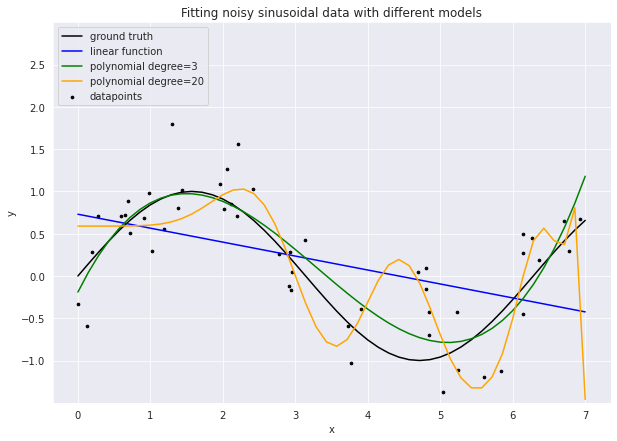

In [35]:
from sklearn.model_selection import train_test_split

# functions to generate the data in this notebook
interval = [0, 7]

def generating_function(t):
    return np.sin(t) # the intrinsic relation between x and y

def make_data(m=30):
    '''
    generate datapoints with a noisy sinusoidal relationship
    '''
    np.random.seed(seed=1)
    X = (interval[1]-interval[0])*np.random.rand(m, 1)+interval[0]
    y = generating_function(X)+0.5*np.random.randn(m, 1) # intrinsic relation + random noise
    return X, y

# generate the data
X, y = make_data(50)
t = np.linspace(*interval) # test set
ground_truth = generating_function(t) # true label of test set

# plot a few different polynomial models
fig, axs = plt.subplots(figsize=(10, 7))
axs.scatter(X, y, s=7, color='black',label="datapoints")
axs.plot(t, ground_truth, label='ground truth', color="black")
colors = ['blue', 'green', 'orange']
labels = ['linear function', 'polynomial degree=3', 'polynomial degree=20']
for i, order in enumerate([1, 3, 20]):
    poly = PolynomialFeatures(degree=order, include_bias=False)
    X_poly = poly.fit_transform(X)
    reg = LinearRegression()
    reg = reg.fit(X_poly, y)
    axs.plot(t, reg.predict(poly.transform(t.reshape(-1, 1))), # plot the learned functions
             color=colors[i], label=labels[i])
axs.set_ylim(np.min(ground_truth)-0.5, 2+np.max(ground_truth))
axs.set_xlabel('x')
axs.set_ylabel('y')
axs.set_title('Fitting noisy sinusoidal data with different models')
axs.legend(loc='upper left')


For each of these models we can calculate the **training MSE** and the **validation MSE**. It can be seen in the following plot that the training MSE (given by the red curve) decreases monotonically as the polynomial degree increases. This makes sense, since the polynomial fit can become as flexible as we need it to be in order to minimise **training MSE**, For the **validation MSE** (given by the blue curve) the situation is quite different. The **validation MSE** initially decreases as we increase the polynomial degree but eventually starts to increase again. 

Why is this? By allowing the model to be extremely complex we are letting it fit to "patterns" in the training data. However, as soon as we assess it on new unseen data points (validation set), the model cannot generalise well because these "patterns" only fit the training data very well and are not the underlying truth, We are in a situation of overfitting.

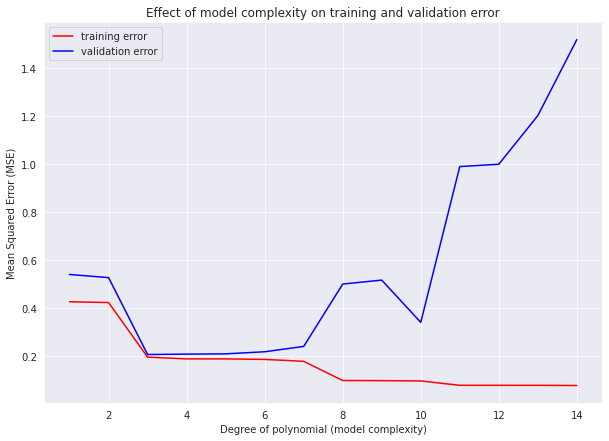

In [36]:
from sklearn.model_selection import train_test_split


def train_validate_poly(X_train, y_train, X_val, y_val, model=LinearRegression, degree=5):
    # train a polynomial model and validate it

    # generate polynomial features
    poly_features = PolynomialFeatures(degree=degree, include_bias=False)
    X_train_poly = poly_features.fit_transform(X_train)
    X_val_poly = poly_features.transform(X_val)

    # learn the model and validate it
    reg = model()
    reg = reg.fit(X_train_poly, y_train)
    y_train_pred = reg.predict(X_train_poly)
    y_val_pred = reg.predict(X_val_poly)
    train_err = mean_squared_error(y_train, y_train_pred)
    val_err = mean_squared_error(y_val, y_val_pred)
    return reg, train_err, val_err

# prepare the data
X, y = make_data(50)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=5)
train_errs = []
val_errs = []

# get training and validation error for different degrees
orders = range(1, 15)
for order in orders:
    _, train_err, val_err = train_validate_poly(X_train, y_train, X_val, y_val, degree=order)
    train_errs.append(train_err)
    val_errs.append(val_err)

# create the plot
fig, axs = plt.subplots(figsize=(10, 7))
axs.plot(orders, train_errs, color='red', label='training error')
axs.plot(orders, val_errs, color='blue', label='validation error')
axs.set_xlabel('Degree of polynomial (model complexity)')
axs.set_ylabel('Mean Squared Error (MSE)')
axs.set_title('Effect of model complexity on training and validation error')
axs.legend()


<div class=" alert alert-warning">

# Student task A6.1:

According to the upper plot, for polynomial degree in $\{2, 3, 10\}$, Which one seems to be the best, 2, 3, or 10?
    
</div>

In [37]:
# write down your answer (an int) as:
answer = 3
assert int(answer) in {2,3,10}, "You should pick 2, 3 or 10."

In [38]:
# this is the test cell for A6.1, please leave it as it is.

# Regularization
Based on the previous demo, it is clear that it would be appropriate to prune the hypothesis space. By pruning we mean only considering a subset of the original hypotheses. In this case, it might be viable to only look at models with $\text{degree} \leq 3$, as shown by our previous analysis above.

However, there are other methods we can use to prune the hypothesis space. We will take a look at two of them: Structural risk minimization (SRM) and data augmentation. Although they are very different at first glance, these two methods are equivalent for linear regression (see sections 7.1 and 7.2 in [MLBook](http://mlbook.cs.aalto.fi)).

## Structural risk minimization (SRM)
This method tries to reduce model complexity by explicitly penalizing large values of the model parameters. Such a penalty term is known as the regularizer $\mathcal{R}(h)\in\mathbb R_+$, and comes in several forms. The cost function that is minimized when training a regularized model is composed of the average loss and an additional **penalty term**:

\begin{equation}
 \hat{\mathbf{w}}^{(\lambda)} = \arg\min_{\mathbf{w}\in\mathbb R^n}\left[\underbrace{\frac{1}{m}\sum_{i=1}^{m} \big(y^{(i)} - h^{(\mathbf{w})}(\mathbf{x}^{(i)}) \big)^{2}}_{\text{MSE}} + \underbrace{\lambda \mathcal{R}(h)}_{\text{penalty term}}\right]
 \end{equation}

The central idea of regularization is that the penalized cost function is minimized by a less complex predictor. Thus, a model trained using the penalized cost function should, in general, have better generalization capabilities provided that the penalty term is well chosen.

The penalty term itself is composed of two factors: a **regularization term** $\mathcal{R}(h)$ and a scaling factor $\lambda$ (in some literature denoted by $\alpha$). The former quantifies a function's complexity, and the latter scales the penalty by a specified factor. Effectively, $\lambda$ **offers a trade-off between the prediction error (training error) incurred on the training data and the complexity of a predictor**. Large $\lambda$ favours less complex predictor functions, while small $\lambda$ puts more emphasis on obtaining a small average loss.

Here we use Ridge regression to illustrate this. Ridge regression is Linear regressions with L2 regularization:
$$
\hat{\mathbf{w}}^{(\lambda)} = \arg\min_{\mathbf{w}\in\mathbb R^n}\left[\frac{1}{m}\sum_{i=1}^{m}\left(y^{(i)}-\mathbf{w}^T\mathbf{x}^{(i)}\right)+\lambda \|\mathbf{w}\|^2_2\right]=
\arg\min_{\mathbf{w}\in\mathbb R^n}\left[\frac{1}{m}\sum_{i=1}^{m}\big(y^{(i)}-\mathbf{w}^T\mathbf{x}^{(i)}\big)+\lambda \sum_{j=1}^{n} \mathbf{w}_j^{2}\right]
$$

From the plot below, it's shown that as $\lambda$ increases (model complexity decreases), training error keeps increasing while validation error decreases, but eventually starts to increase again.

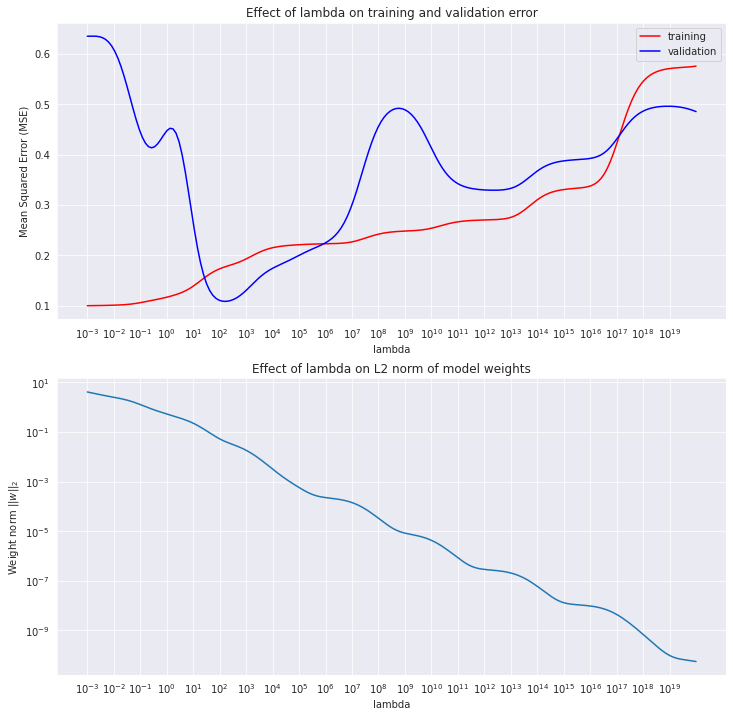

In [39]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge

# create the data
X, y = make_data(50)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=2)
degree = 15

# iteratively try different lambdas
regs = []
train_errs = []
val_errs = []
l_range = (-3, 20)
lambdas = np.logspace(*l_range, num=200)  # candidate lambdas
for l in lambdas:
    reg, train_err, val_err = train_validate_poly(
        X_train, y_train, X_val, y_val, lambda: Ridge(alpha=l, solver='svd'), degree=degree)
    regs.append(reg)
    train_errs.append(train_err)
    val_errs.append(val_err)
fig, axs = plt.subplots(2, 1, figsize=(12, 12))

# plot the data
plt.setp(axs, xscale='log', xticks=[10**x for x in range(*l_range)], xlabel='lambda', ylabel='Mean Squared Error (MSE)')
axs[0].plot(lambdas, train_errs, color='red', label='training')
axs[0].plot(lambdas, val_errs, color='blue', label='validation')
axs[0].set_title('Effect of lambda on training and validation error')
axs[0].legend()

axs[1].set_yscale('log')
axs[1].plot(lambdas, [np.linalg.norm(reg.coef_) for reg in regs])
axs[1].set_ylabel('Weight norm $||w||_2$')
axs[1].set_title('Effect of lambda on L2 norm of model weights')
plt.show()

<div class="alert alert-warning">

# Student Task A6.2:

According to the upper plot, which lambda out of the set $\{0.1,1,10,100,1000,10000\}$ would you choose?
</div>

In [40]:
# write down your answer as:
answer = 10

assert answer in {0.1,1,10,100,1000,10000}, "Invalid answer, pick one from the set."

In [41]:
#this cell is for test of A6.2, please leave it as it is.

## Data augmentation
One way to combat overfitting is to get more training data. Unfortunately, this is not always feasible, be it due to budget constraints (need to pay people to label the data) or time constraints. The idea behind data augmentation is to use datapoints that are already available to generate new ones, thus enlarging the training dataset.

When dealing with image classification, new images can be generated e.g. by rotating, cropping or changing pixel values slightly, since these don't change the class (flipping a dog upside down doesn't make it a cat). Our assignment problem is simpler and we will augment the data by adding perturbations generated by a normal distribution with zero mean, $\varepsilon\sim\mathcal{N}(0,\sigma^2)$, to our training samples.

<div class=" alert alert-warning">

# Student task A6.3:
Write a function ``augment_data`` that takes numpy arrays $X=[x_1,x_2,\dots,x_m]^T$ and $y=[y_1,y_2,\dots,y_m]^T$, both of which of shape ``(m,1)``, a positive integer ``n_perturbations`` and a float ``std`` and returns numpy arrays $X_{\text{augmented}}$ and $y_{\text{augmented}}$ of shape ``(n_perturbations*m, 1)`` that are created as follows. 

First generate a randome vector of perturbations $\varepsilon=(\varepsilon_1, \dots, \varepsilon_n)$, where ``n=n_perturbations``, each of which is sampled from a normal distribution with zero mean and standard deviation ``std``. Then, create a new array $X_{\text{augmented}}=[X^T+\epsilon_1, X^T+\epsilon_2,\dots,X^T+\epsilon_n]^T$. Note that we used a slight abuse of notation $X+\epsilon_i:=[x_1+\varepsilon_i, x_2+\varepsilon_i,\dots,x_m+\varepsilon_i]^T$. This is something numpy calls [broadcasting](https://numpy.org/doc/stable/user/basics.broadcasting.html) and you can use it to make your code simpler. Array ``y_augmented`` is created simply by having ``y`` repeated ``n``-times, so that the perturbed datapoints still correspond to the same labels.  

Tips:
* The [numpy.random.normal](https://numpy.org/doc/stable/reference/random/generated/numpy.random.normal.html) and [numpy.concatenate](https://numpy.org/doc/stable/reference/generated/numpy.concatenate.html?highlight=concatenate#numpy.concatenate) functions might be useful for this task.
* Use the view_augmentation function to check if your function does what it should. Check the L7 slides, p. 37 and compare the plots. **Do they look similar?**
</div>

In [42]:
def augment_data(X, y, n_perturbations, std):
    """
    Data augmentation function.
    inputs: X, the original feature matrix, X.shape=(m,1)
            y, the original featrue matrix, y.shape=(m,1)
            n_perturbations, number of perturbations, int
            std, standard deviation of perturbations, float
            
    outputs: X_augmented, the augmented feature matrix, X_augmented.shape=(m*n,1)
             y_augmented, the augmented labels, y_augmented.shape=(m*n,1)
    """
    # YOUR CODE HERE
    ## generate the perturbations
    perturbations = np.random.normal(loc=0, scale=1, size=n_perturbations) # a random vector with n elements, i.e. size=n
    
    aug_Xs = [X+pert for pert in perturbations] # a list of arrays, each array is an augmented X with a particular perturbation
    aug_ys = [y for pert in perturbations] # a list of augmented y, Note: no value changes for y
    

    ## generate the augmented training set, the number of datapoints is m*n
    X_augmented = np.concatenate(aug_Xs, axis=0)  # concatenate augmented Xs vertically, i.e. along axis 0
    y_augmented = np.concatenate(aug_ys, axis=0)  # concatenate augmented ys vertically, i.e. along axis 0
    
    return X_augmented, y_augmented


def view_augmentation(n_perturbations=10, std=1e-1):
    # generate data
    X, y = make_data(20)

    # illustrate augmentation
    plt.figure()
    plt.title("Augmentation illustration")
    plt.xlabel("x")
    plt.ylabel("y")

    plt.scatter(*augment_data(X, y, n_perturbations, std), label="augmented datapoints")
    plt.scatter(X, y, label="original datapoints")
    plt.legend()


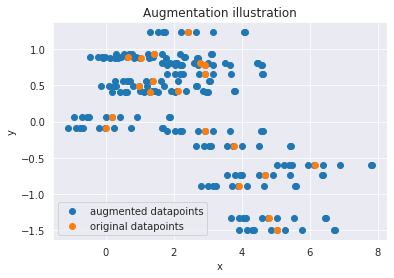

In [43]:
assert augment_data(np.zeros((5, 1)), np.zeros((5, 1)), 10, 0.1)[0].shape == (50, 1), "Incorrect shape of X_augmented"
assert augment_data(np.zeros((5, 1)), np.zeros((5, 1)), 10, 0.1)[1].shape == (50, 1), "Incorrect shape of y_augmented"
view_augmentation()

In [44]:
X

array([[2.91915403e+00],
       [5.04227145e+00],
       [8.00623721e-04],
       [2.11632801e+00],
       [1.02729124e+00],
       [6.46370163e-01],
       [1.30382148e+00],
       [2.41892509e+00],
       [2.77737232e+00],
       [3.77171714e+00],
       [2.93436160e+00],
       [4.79653650e+00],
       [1.43116575e+00],
       [6.14682205e+00],
       [1.91713152e-01],
       [4.69327257e+00],
       [2.92113362e+00],
       [3.91082880e+00],
       [9.82708570e-01],
       [1.38671042e+00],
       [5.60521198e+00],
       [6.77783103e+00],
       [2.19396925e+00],
       [4.84625831e+00],
       [6.13472407e+00],
       [6.26224664e+00],
       [5.95309480e-01],
       [2.73383483e-01],
       [1.18881294e+00],
       [6.14699752e+00],
       [6.88427837e-01],
       [2.94775338e+00],
       [6.70522671e+00],
       [3.73215699e+00],
       [4.84313980e+00],
       [2.20860942e+00],
       [4.80550649e+00],
       [5.84237970e+00],
       [1.28017941e-01],
       [5.25101020e+00],


In [45]:
# this cell is for test of A6.3



In the cell below, we use the ``augment_data`` method you implemented to show the dependence between augmentation standard deviation and validation error for polynomials models of different degrees. Because we're using a low number of datapoints, the trained models can change significantly even with small changes in the data, which leads to "noisy" curves. We therefore use a median filter to make them smoother and make the plot clearer. 

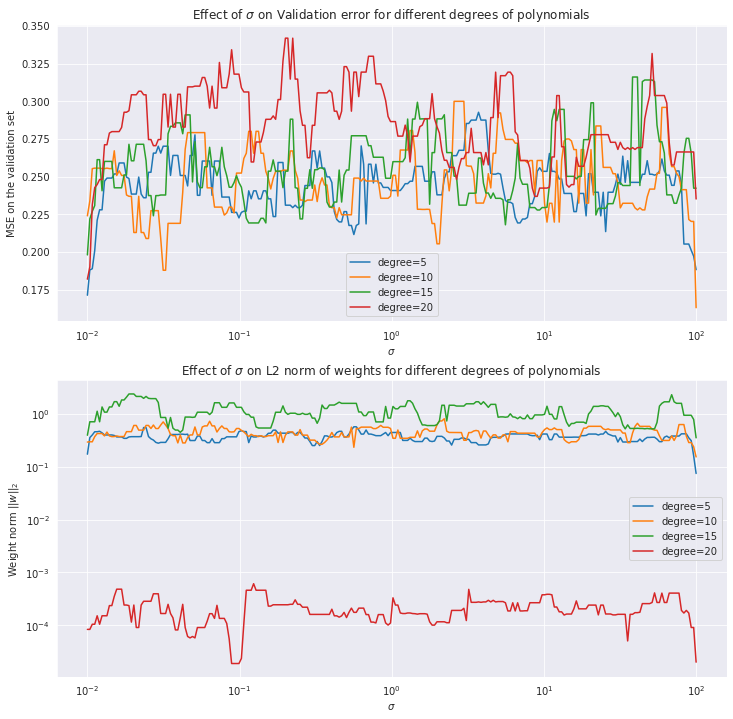

In [47]:
"""Note: this cell is editable for you to try out different values for degree and sigma"""
# generate data
from scipy.signal import medfilt
X, y = make_data(50)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=42)

smoothing = 9

# generate plot data
plot_data = []
sigmas = np.logspace(-2, 2, 250)
degrees = [5, 10, 15, 20]
for deg in degrees:
    train_errs = []
    val_errs = []
    regs = []
    for sigma in sigmas:
        reg, train_err, val_err = train_validate_poly(
            *augment_data(X_train, y_train, 10, sigma),
            X_val, y_val, degree=deg)
        train_errs.append(train_err)
        val_errs.append(val_err)
        regs.append(reg)
    plot_data.append({"deg": deg, "x": sigma, "train_errs": train_errs, "val_errs": val_errs,
                     "weight_norms": [np.linalg.norm(reg.coef_, 1) for reg in regs]})

# plots wrt. number of augmented datapoints
fig, axs = plt.subplots(2, 1, figsize=(12, 12))
for p in plot_data:
    axs[0].plot(sigmas, medfilt(p["val_errs"], smoothing), label=f'degree={p["deg"]}')
    axs[1].plot(sigmas, medfilt(p["weight_norms"], smoothing), label=f'degree={p["deg"]}')
axs[1].set_yscale('log')
axs[0].set_xscale('log')
axs[1].set_xscale('log')
axs[0].set_xlabel('$\sigma$')
axs[0].set_ylabel('MSE on the validation set')
axs[0].set_title('Effect of $\sigma$ on Validation error for different degrees of polynomials')
axs[0].legend()
axs[1].set_xlabel('$\sigma$')
axs[1].set_ylabel('Weight norm $||w||_2$')
axs[1].set_title('Effect of $\sigma$ on L2 norm of weights for different degrees of polynomials')
axs[1].legend()
plt.show()

<div class=" alert alert-warning">

# Student task A6.4:
Carefully observe the upper plots and play with the parameters in the previous cell for a bit to answer the following questions (especially Q1 and Q2): 
* Q1: Is the polynomial model of degree 5 guaranteed to always have lower validation error than the polynomial of degree 20, no matter the augmentation standard deviation? 
    * 0: No
    * 1: Yes
* Q2: When is data augmentation most useful? 
    * 0: When there's not enough training data.
    * 1: When there's too much training data.
    * 2: This does not depend on training data quantity.
* Q3: Why is the validation error very similar for small standard deviation of the added noise as it is for the original data?
    * 0: The model that fits the original data fits such augmented data almost equally well.
    * 1: The model gets confused by too many similar datapoints.
    * 2: The augmented data is not representative of the original data. 
* Q4: Why does the validation error start to rise again when we keep increasing the standard deviation of the added noise?
    * 0: There's too many datapoints.
    * 1: The augmented data starts to be too similar to the original data again.
    * 2: The augmented data is no longer representative of the original data. 

</div>

In [48]:
A1= 0 # 0: No, 1: Yes
A2= 0 # 0: When there's not enough training data, 1: When there's too much training data, 2: This does not depend on training data.
A3= 1 # 0: The model that fits the original data fits such augmented data almost equally well, 1: The model gets confused by too many similar datapoints, 2: The augmented data is not representative of the original data. 
A4= 2 # 0: There's too many datapoints, 1: The augmented data starts to be too similar to the original data again, 2: The augmented data is no longer representative of the ground truth.


assert A1 in {0, 1}
assert A2 in {0, 1, 2}
assert A3 in {0, 1, 2}
assert A4 in {0, 1, 2}


In [49]:
# test cell for A6.4

In [50]:
# test cell for A6.4

In [51]:
# test cell for A6.4

In [52]:
# test cell for A6.4

### Demo
As you can see in the plot below, adding regularization significantly helps the problem of increasing validation error for higher polynomial degrees. Note, however, that a model with polynomial degree 5 still manages to get a better fit.

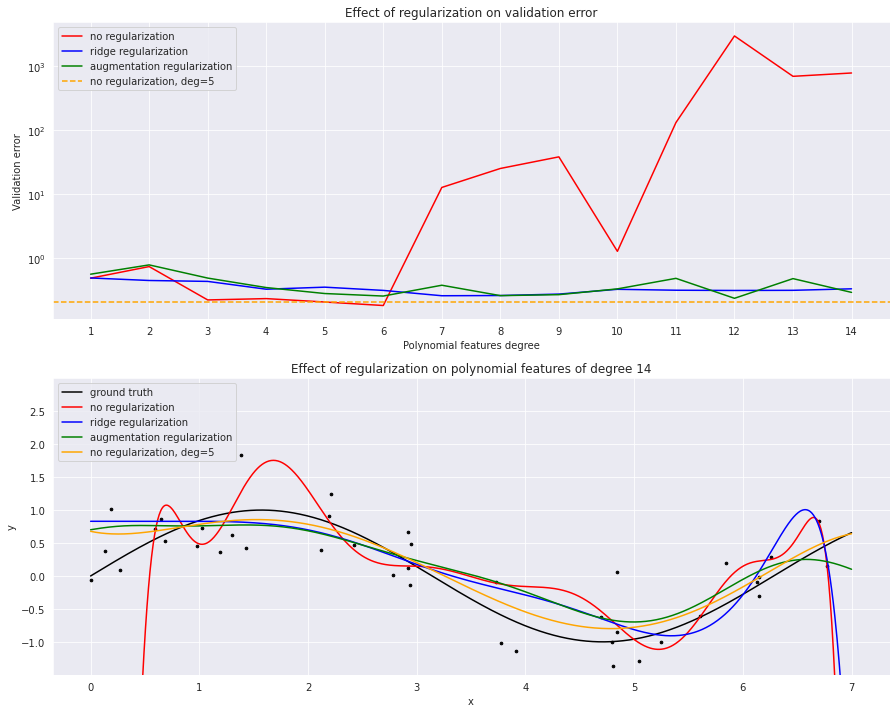

In [53]:
# prepare the data
X, y = make_data(40)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=2)
val_errs = []
val_errs_ridge = []
val_errs_augmentation = []
regs = []
regs_ridge = []
regs_augmentation = []

# generate the data
max_deg = 15
orders = range(1, max_deg)
for order in orders:
    reg, _, val_err = train_validate_poly(X_train, y_train, X_val, y_val, degree=order)
    reg_ridge, _, val_err_ridge = train_validate_poly(X_train, y_train, X_val, y_val,
                                                      lambda: Ridge(alpha=1e3, solver='svd'), degree=order)
    reg_augmentation, _, val_err_augmentation = train_validate_poly(
        *augment_data(X_train, y_train, order, 0.8), X_val, y_val, degree=order)
    val_errs.append(val_err)
    val_errs_ridge.append(val_err_ridge)
    val_errs_augmentation.append(val_err_augmentation)
    regs.append(reg)
    regs_ridge.append(reg_ridge)
    regs_augmentation.append(reg_augmentation)
reg5, _, val_err5 = train_validate_poly(X_train, y_train, X_val, y_val, degree=5)

# plot
fig, axs = plt.subplots(2, 1, figsize=(15, 12))
axs[0].plot(orders, val_errs, color='red', label='no regularization')
axs[0].plot(orders, val_errs_ridge, color='blue', label='ridge regularization')
axs[0].plot(orders, val_errs_augmentation, color='green', label='augmentation regularization')
axs[0].axhline(y=val_err5,color="orange",linestyle='--',label="no regularization, deg=5")
axs[0].set_yscale('log')
axs[0].set_xticks(np.arange(1, max_deg))
axs[0].set_xlabel('Polynomial features degree')
axs[0].set_ylabel('Validation error')
axs[0].set_title('Effect of regularization on validation error')
axs[0].legend()


t = np.linspace(*interval, 1000)
ground_truth = generating_function(t)
t_poly = PolynomialFeatures(degree=max_deg-1, include_bias=False).fit_transform(t.reshape(-1, 1))
t_poly5 = PolynomialFeatures(degree=5, include_bias=False).fit_transform(t.reshape(-1, 1))

# plot a few different polynomial models
axs[1].scatter(X, y, s=7, color='black')
axs[1].plot(t, ground_truth, label='ground truth', color="black")

axs[1].plot(t, regs[-1].predict(t_poly), color='red', label='no regularization')
axs[1].plot(t, regs_ridge[-1].predict(t_poly), color='blue', label='ridge regularization')
axs[1].plot(t, regs_augmentation[-1].predict(t_poly), color='green', label='augmentation regularization')
axs[1].plot(t, reg5.predict(t_poly5), color='orange', label='no regularization, deg=5')

axs[1].set_ylim(np.min(ground_truth)-0.5, 2+np.max(ground_truth))
axs[1].set_xlabel('x')
axs[1].set_ylabel('y')
axs[1].set_title(f'Effect of regularization on polynomial features of degree {max_deg-1}')
axs[1].legend(loc='upper left')
